# ALE

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor as RFR
from alibi.explainers import ALE, plot_ale

import os

dp = os.environ.get('pub_data')

In [3]:
from ucimlrepo import fetch_ucirepo 

In [4]:
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 
  
# metadata 
print(abalone.metadata) 
  
# variable information 
print(abalone.variables)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [5]:
data = pd.concat([X, y], axis=1)

## Explaining ALEs

<Axes: >

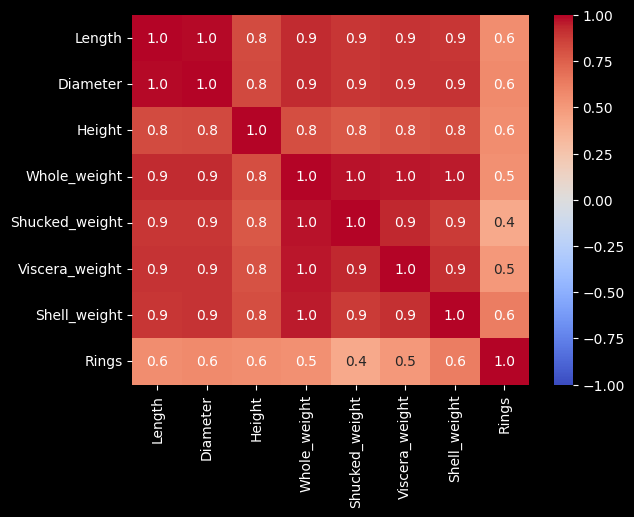

In [6]:
# Correlation heatmap
cont = [
    "Length",
    "Diameter",
    "Height",
    "Whole_weight",
    "Shucked_weight",
    "Viscera_weight",
    "Shell_weight",
    "Rings",
]
corr_matrix = pd.DataFrame(data[cont], columns=cont).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", fmt=".1f", vmin=-1, vmax=1,annot=True)

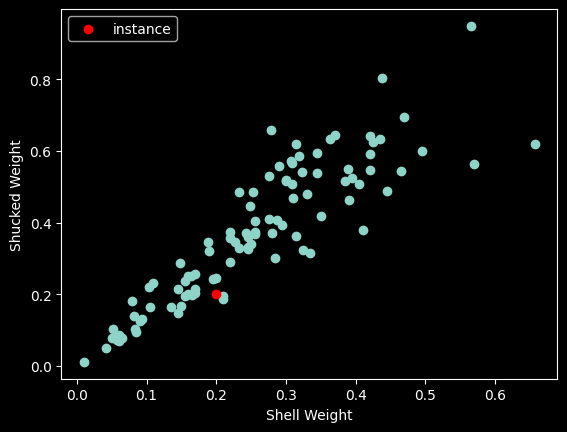

In [7]:
# scatter plot of shell weight vs shucked weight
sample = data.sample(100)

plt.scatter(sample['Shell_weight'], sample['Shucked_weight'])

# add red point for sample
plt.scatter(0.2, 0.2, color='red',label='instance')

plt.xlabel('Shell Weight')
plt.ylabel('Shucked Weight')
plt.legend()

Text(0, 0.5, 'Shucked Weight')

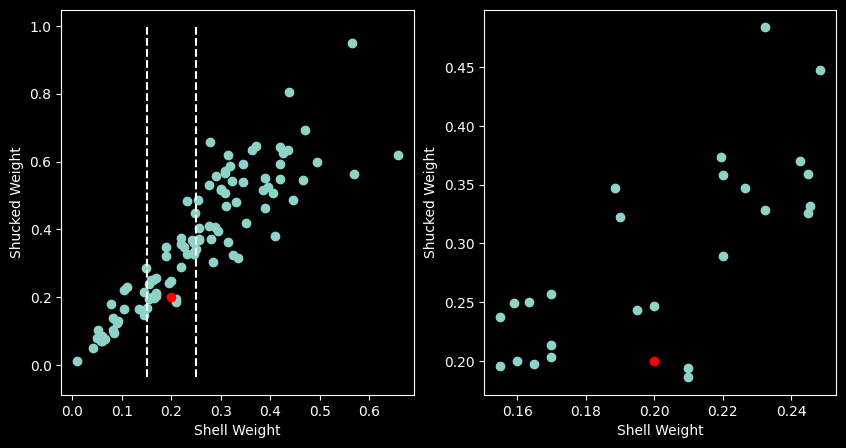

In [20]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))

# show interval
ax[0].scatter(sample['Shell_weight'], sample['Shucked_weight'])
ax[0].scatter(0.2, 0.2, color='red',label='instance')

ymin, ymax = ax[0].get_ylim()
ax[0].vlines(x=0.15, ymin=ymin, ymax=ymax, color='white', linestyle='--')
ax[0].vlines(x=0.25, ymin=ymin, ymax=ymax, color='white', linestyle='--')

ax[0].set_xlabel('Shell Weight')
ax[0].set_ylabel('Shucked Weight')

# plot points within interval
sample_in_interval = sample[(sample['Shell_weight'] > 0.15) & (sample['Shell_weight'] < 0.25)]
ax[1].scatter(sample_in_interval['Shell_weight'], sample_in_interval['Shucked_weight'])
ax[1].scatter(0.2, 0.2, color='red',label='instance')

ax[1].set_xlabel('Shell Weight')
ax[1].set_ylabel('Shucked Weight')

/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_54253/3539182465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample__1p5['Shell_weight'] = [0.15 for i in range(len(sample__1p5))]


Text(0, 0.5, 'Shucked Weight')

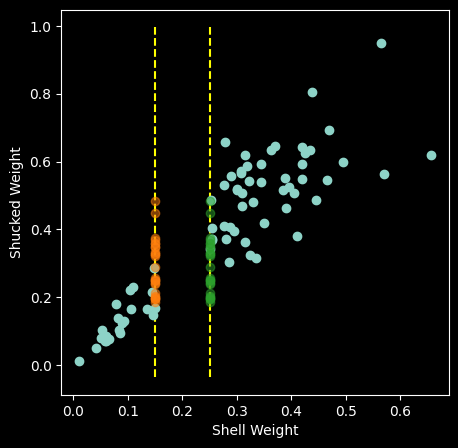

In [21]:
# get data for explanation plot
sample_adjusted = sample.copy()
sample__1p5 = sample_adjusted[(sample_adjusted['Shell_weight'] < 0.25) & (sample_adjusted['Shell_weight'] > 0.15)]
sample__1p5['Shell_weight'] = [0.15 for i in range(len(sample__1p5))]

sample_2p5 = sample__1p5.copy() 
sample_2p5['Shell_weight'] = [0.25 for i in range(len(sample_2p5))]

sample_adjusted = sample[(sample['Shell_weight'] >= 0.25)]
sample_adjusted = pd.concat([sample_adjusted, sample[(sample['Shell_weight'] <= 0.15)]], axis=1)


fig, ax = plt.subplots(1,1,figsize=(5, 5))
# show new sample points
ax.scatter(sample_adjusted['Shell_weight'], sample_adjusted['Shucked_weight'])
ax.scatter(sample_2p5['Shell_weight'], sample_2p5['Shucked_weight'],alpha=0.5,color='tab:green')
ax.scatter(sample__1p5['Shell_weight'], sample__1p5['Shucked_weight'],alpha=0.5,color='tab:orange')
ax.vlines(x=0.15, ymin=ymin, ymax=ymax, color='yellow', linestyle='--',zorder=-1)
ax.vlines(x=0.25, ymin=ymin, ymax=ymax, color='yellow', linestyle='--',zorder=-1)

ax.set_xlabel('Shell Weight')
ax.set_ylabel('Shucked Weight')

## Model

In [10]:
y = data["Rings"]
X = data[["Sex", "Length", "Height", "Shucked_weight", "Viscera_weight", "Shell_weight"]]

# Create dummy variables
X['Sex.M'] = [1 if s == 'M' else 0 for s in X['Sex']]
X['Sex.F'] = [1 if s == 'F' else 0 for s in X['Sex']]
X['Sex.I'] = [1 if s == 'I' else 0 for s in X['Sex']]
X = X.drop('Sex', axis=1)

X.head()

/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_54253/3031051756.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex.M'] = [1 if s == 'M' else 0 for s in X['Sex']]
/var/folders/h4/7cr1cmpn7v5b3x20_9wz8m740000gn/T/ipykernel_54253/3031051756.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex.F'] = [1 if s == 'F' else 0 for s in X['Sex']]


,Length,Height,Shucked_weight,Viscera_weight,Shell_weight,Sex.M,Sex.F,Sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


In [11]:
# Train model
model = RFR()
model.fit(X.to_numpy(), y)

RandomForestRegressor()

/Users/du/miniforge3/envs/xai/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Text(0.5, 0, 'Actual')

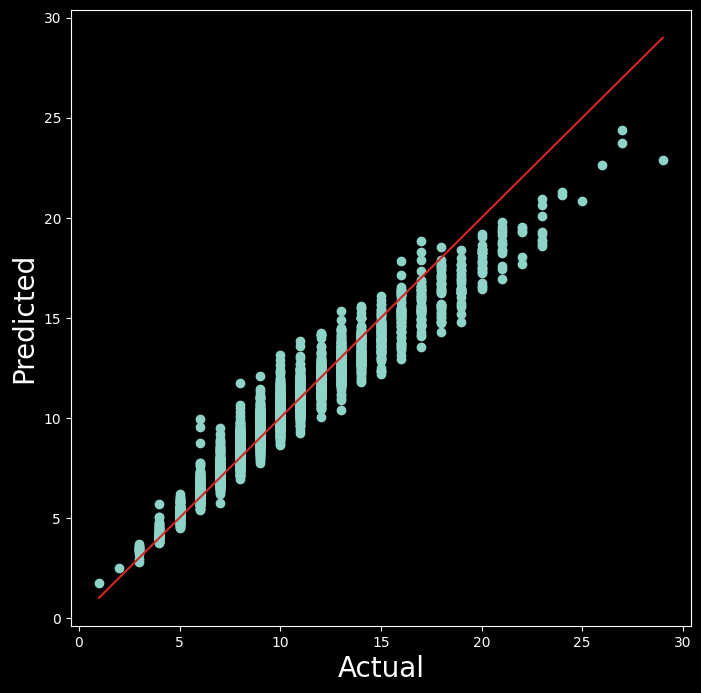

In [12]:
#Get predictions
y_pred = model.predict(X)

# Model evaluation
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

plt.scatter(y,y_pred)
ax.plot([y.min(), y.max()], [y.min(), y.max()], color='tab:red')

plt.ylabel('Predicted',size=20)
plt.xlabel('Actual',size=20)

## Accumulated Local Effects (ALEs)

In [13]:
# Get ALE explanation
ale = ALE(model.predict , feature_names=X.columns, target_names=['Rings'])
exp = ale.explain(X.to_numpy())

array([[<Axes: xlabel='Length', ylabel='ALE'>,
        <Axes: xlabel='Height', ylabel='ALE'>,
        <Axes: xlabel='Shucked_weight', ylabel='ALE'>]], dtype=object)

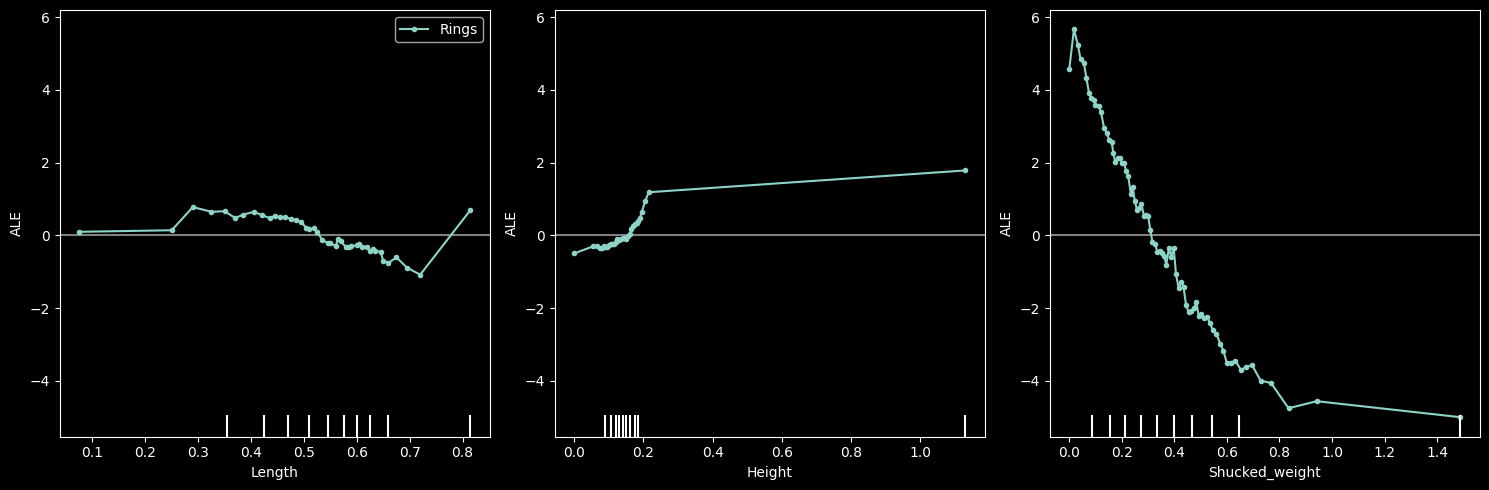

In [26]:
# Plot ALE explanation for first 3 features
plot_ale(exp, features=[0,1,2], fig_kw={'figwidth':15, 'figheight': 5})

Text(0.5, 0, 'Weight')

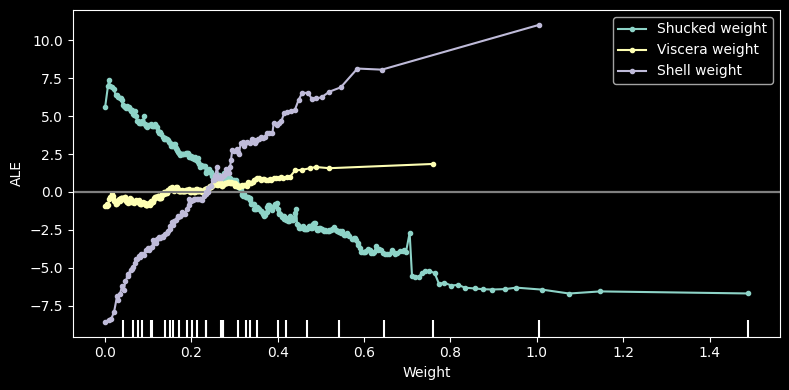

In [15]:
# Plot ALE for weight features
fig, ax = plt.subplots(1, 1, figsize=(8, 4))


plot_ale(exp, features=[2], ax=ax, line_kw={'label': 'Shucked weight'})
plot_ale(exp, features=[3], ax=ax, line_kw={'label': 'Viscera weight'})
plot_ale(exp, features=[4], ax=ax, line_kw={'label': 'Shell weight'})

ax.set_xlabel('Weight')

In [16]:
# Adjust intervals
ale = ALE(model.predict , feature_names=X.columns, target_names=['Rings'])
exp = ale.explain(X.to_numpy(),min_bin_points=50)

Text(0.5, 0, 'Weight')

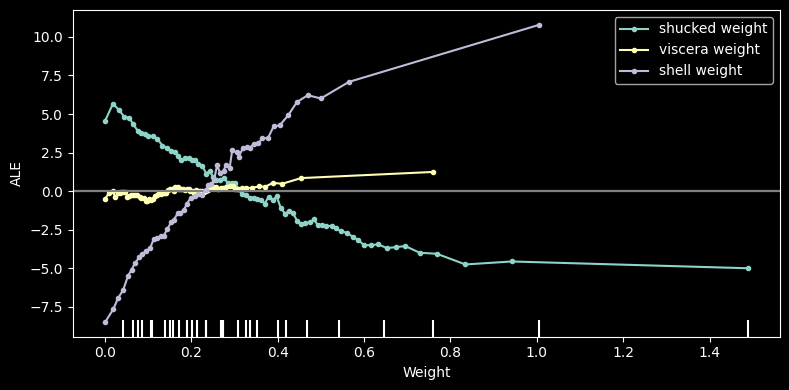

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plot_ale(exp, features=[2], ax=ax, line_kw={'label': 'shucked weight'})
plot_ale(exp, features=[3], ax=ax, line_kw={'label': 'viscera weight'})
plot_ale(exp, features=[4], ax=ax, line_kw={'label': 'shell weight'})

ax.set_xlabel('Weight')

[]

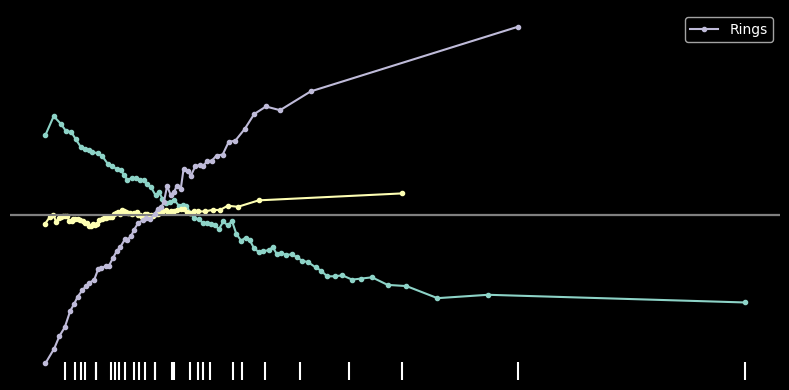

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

plot_ale(exp, features=[2], ax=ax, line_kw={})
plot_ale(exp, features=[3], ax=ax, line_kw={})
plot_ale(exp, features=[4], ax=ax, line_kw={})

ax.axis('off')

# 去掉坐标轴的spines
for spine in ax.spines.values():
    spine.set_visible(False)
# ax.set_xlabel('Weight')
ax.set_xticks([])
ax.set_yticks([])